In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv(f'E:/Python_ML_projects/credit_risk_analysis/credit_risk_dataset.csv')

In [131]:
df = data.copy()

# Feature Engineering:

In this step, the data will be modified to enhance the quality of our analysis. I chose the person_age column to split into categories because having a wide range of ages in a single column might negatively impact our analysis. Theoretically, there should be no direct dependence between age and loan_status. For this reason, I divided the data into five age categories and created a new column called age_category. We could apply a similar approach to other age-related columns, such as person_emp_length and cb_person_cred_hist_length.

Additionally, I removed rows with unrealistic values, such as person_age > 100 and person_emp_length > 60.

In [4]:
def feature_engineering(dataset):
    dataset = dataset.drop(dataset[dataset['person_age'] > 100].index, axis=0)
    dataset = dataset.drop(dataset[dataset['person_emp_length'] > 60].index, axis=0)
    dataset['age_catego'] = pd.cut(dataset['person_age'],
                           bins=[18, 30, 40, 50, 60, 100],
                           labels=['20-30', '31-40', '41-50', '51-60', '60+'])
    dataset['age_catego'] = dataset['age_catego'].astype('object')
    dataset = dataset.drop(['person_age'], axis=1)
    return dataset

In [5]:
df = feature_engineering(df)
df

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_catego
1,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,20-30
2,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,20-30
3,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,20-30
4,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,20-30
5,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2,20-30
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30,51-60
32577,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19,51-60
32578,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28,60+
32579,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26,51-60


## Preprocessing function

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [7]:
df.isna().sum()/df.shape[0]

person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027476
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.095628
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
age_catego                    0.000000
dtype: float64

In [133]:
import warnings
warnings.filterwarnings("ignore")
# this is just to avoid long warning messages

In [8]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=3)

In [9]:
trainset['loan_status'].value_counts()

loan_status
0    20309
1     5750
Name: count, dtype: int64

In [10]:
testset['loan_status'].value_counts()

loan_status
0    5158
1    1357
Name: count, dtype: int64

### Note : We observed that negative values are four times more frequent than positive values. This means that accuracy is not an effective scoring method for this dataset. Instead, we will need to use metrics like F1 or recall score.

Encoder function:

Since our dataset contains both continuous and categorical columns, we will need to convert the categorical columns to numerical format using the OneHotEncoder function:

In [11]:
def encoder(dataset):    
    encoded_df = pd.DataFrame()
    encoder_type = OneHotEncoder(handle_unknown='ignore', sparse=False).set_output(transform ='pandas')
    for col in dataset.select_dtypes('object'):
        ohe = encoder_type.fit_transform(dataset[[col]]) 
        ohe.columns = [f"{cat}" for cat in ohe.columns] #renaming the columns   
        encoded_df = pd.concat([encoded_df, ohe], axis=1) # we should concatene the new columns with previous
    df1_encoded = pd.concat([dataset, encoded_df], axis=1).drop(columns=dataset.select_dtypes('object').columns) # we dropp previous version of object columns

    return df1_encoded 


Imputation Function:

Since we have null values in the dataset, we need to handle them appropriately. The first option is to drop all rows with NaN values, and the second option is to replace them with suitable values. I chose the first option, but you can also experiment with the second approach.

In [12]:
def imputation(dataset):
    return dataset.dropna(axis=0)

Prepocessing function:

Finally, I created a preprocessing function that includes all data preparation steps, such as feature engineering, encoding, and imputation.

In [13]:
def prepocessing(dataset):

    dataset = encoder(dataset)
    dataset = imputation(dataset)
    X = dataset.drop('loan_status', axis = 1)
    y = dataset['loan_status']

    print(y.value_counts())

    return X, y


We will prepare both the training and test data simply by running the preprocessing function.

In [132]:
X_train, y_train = prepocessing(trainset)
X_test, y_test = prepocessing(testset)

loan_status
0    17944
1     4961
Name: count, dtype: int64
loan_status
0    4486
1    1241
Name: count, dtype: int64


# Step by step anlysis:

Here, we begin selecting the machine learning algorithms. First, I’ll choose an initial model to analyze, and then I’ll work on improving its performance through parameter tuning and feature selection

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

First, I started with the DecisionTreeClassifier. I set only the max_depth parameter to observe the relationship between the model's score and this parameter

best score is 0.9526115983767509 with k = 14


Text(0, 0.5, 'score')

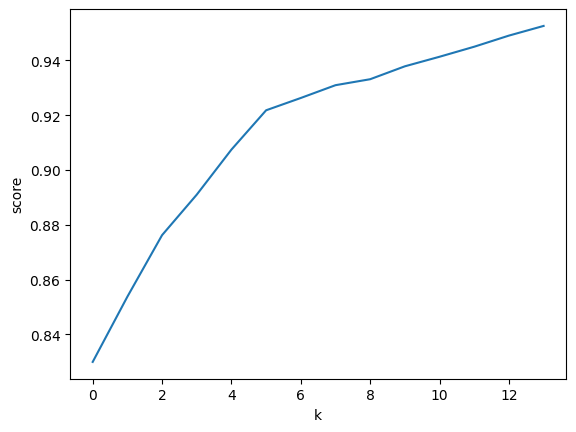

In [16]:
score = []
best_k = 1
best_score = 0

for k in range (1,15):
    model = DecisionTreeClassifier(max_depth=k)
    model.fit(X_train, y_train)
    model_score = model.score(X_train, y_train)
    score.append(model_score)
    if best_score < model_score :
        best_score = model_score
        best_k = k

print(f'best score is {best_score} with k = {best_k}')
plt.plot(score)
plt.xlabel('k')
plt.ylabel('score')


The score is good, but the issue is that it’s based on the 'accuracy' metric, and we haven’t applied cross-validation to achieve a more reliable performance assessment.

### Cross Validation

The cross_val_score function performs cross-validation on a given model. It splits the data into several subsets (or folds), then trains and evaluates the model on each fold separately, providing a reliable measure of the model's average performance across the entire dataset

In [17]:
from sklearn.model_selection import cross_val_score

best score is 0.8074335164029321 with k = 10


Text(0, 0.5, 'score')

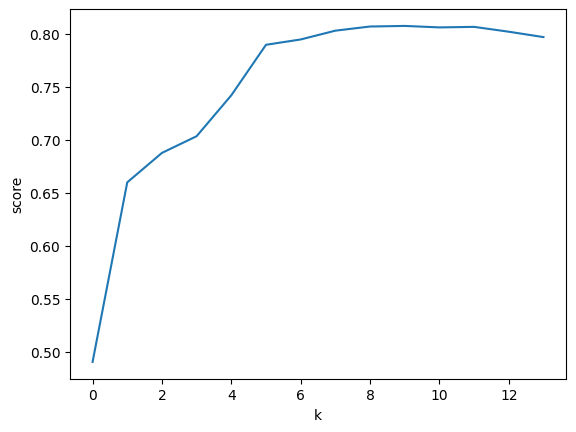

In [18]:
validation_score = []
best_k = 1
best_score = 0
for k in range (1,15):
    score = cross_val_score(DecisionTreeClassifier(max_depth=k), X_train, y_train, cv=5, scoring = 'f1').mean()
    validation_score.append(score)
    if best_score < score:
        best_score = score
        best_k = k 
print(f'best score is {best_score} with k = {best_k}')
plt.plot(validation_score)
plt.xlabel('k')
plt.ylabel('score')

### Validation_curve

The validation_curve function, on the other hand, is used to analyze how the model's performance changes with respect to a specific hyperparameter

In [19]:
from sklearn.model_selection import validation_curve

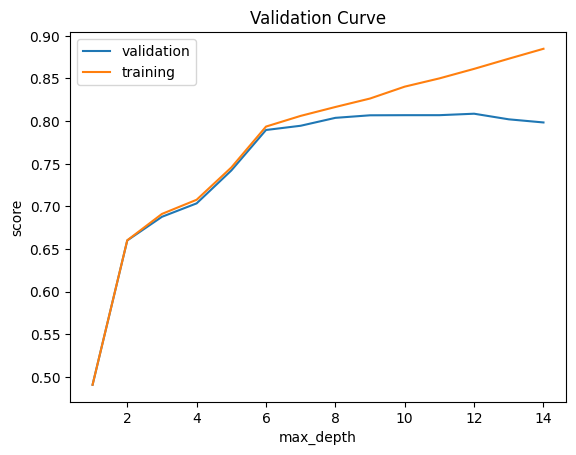

In [20]:
k= np.arange(1,15)

train_score, val_score = validation_curve(model, X_train, y_train, param_name='max_depth', param_range=k, cv=5, scoring = "f1")

plt.plot(k, val_score.mean(axis=1), label = 'validation')
plt.plot(k, train_score.mean(axis=1), label = 'training')

plt.ylabel("score")
plt.xlabel("max_depth")
plt.title('Validation Curve')
plt.legend()

We can see that after a max_depth of 11, the validation performance decreases while the training performance increases, which indicates convergence towards overfitting. In summary, for the max_depth parameter, 11 seems to be a good choice. Now, we will consider adding another parameter to improve the score

### GridsearchCV

GridSearchCV is a method used to perform an exhaustive search over a specified parameter grid. It evaluates all possible combinations of hyperparameters, using cross-validation to identify the best set of parameters for the model, ultimately improving its performance

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 14,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [23]:
grid_param = {'max_depth' : np.arange(1, 20), 
              'criterion': ["gini", "entropy", "log_loss"] 
              }

grid_model = GridSearchCV(DecisionTreeClassifier(random_state=0), grid_param, cv = 5, scoring='f1')
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_score_)

{'criterion': 'entropy', 'max_depth': 11}
0.8124871607520554


The value of grid_model.best_score_ is the average cross-validation score across the 5 folds (cv=5) for the best combination of parameters.

### Confusion_matrix and Classification report

The confusion matrix is a performance evaluation tool used to assess the accuracy of a classification model. It shows the counts of true positive, true negative, false positive, and false negative predictions, helping to understand the types of errors the model is making

In [24]:
model = grid_model.best_estimator_
print(model)

DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=0)


In [25]:
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
confusion_matrix(y_test, model.predict(X_test))


array([[4472,   65],
       [ 322,  856]], dtype=int64)

The classification report provides key metrics to evaluate a classification model, including precision, recall, F1-score, and support for each class. It helps assess the model's performance in terms of both overall accuracy and class-specific metrics

In [27]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4537
           1       0.93      0.73      0.82      1178

    accuracy                           0.93      5715
   macro avg       0.93      0.86      0.89      5715
weighted avg       0.93      0.93      0.93      5715



### Learning_curve

learning curve is a graphical representation of a model's performance over time, showing how the training and validation scores evolve as more training data is used. It helps identify whether the model is underfitting, overfitting, or achieving optimal performance.

It also shows whether more data is needed to achieve the best performance, or if the current amount is sufficient, helping us avoid paying more for additional data, as it can sometimes be costly.

In [28]:
from sklearn.model_selection import learning_curve

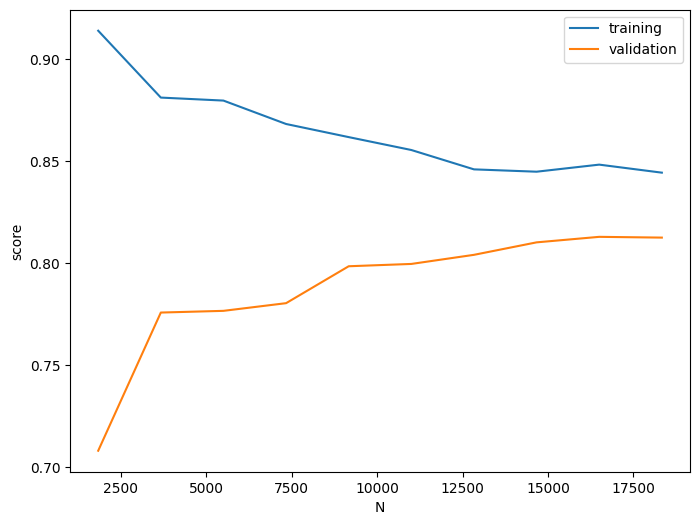

In [29]:

N, train_score, val_score = learning_curve(
        model, X_train, y_train, 
        cv=5, scoring='f1', 
        train_sizes=np.linspace(0.1, 1, 10)
    )



plt.figure(figsize=(8, 6))
plt.plot(N, train_score.mean(axis=1), label = 'training')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.xlabel('N')
plt.ylabel('score')
plt.legend()

### Performance_report function:

This function will include all the steps mentioned above to assess the performance of each model and will be used in the analysis of all subsequent models

In [30]:
def performance_report(model):

    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    acccuracy = accuracy_score(y_test, ypred)
    recall = recall_score(y_test, ypred, average="weighted")
    precision = precision_score(y_test, ypred, average="weighted")
    f1 = f1_score(y_test, ypred, average="weighted")

    validation_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()

    print("Accuracy    : ", acccuracy)
    print("Recall      : ", recall)
    print("Precision   : ", precision)
    print("F1 Score    : ", f1)
    print(f"Validation score :  {validation_score}\n")

    print(confusion_matrix(y_test, ypred), "\n")
    print(classification_report(y_test, ypred))

    N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                               cv=5,  scoring= 'f1', 
                                               train_sizes =np.linspace(0.1, 1 ,10))

    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label= 'train score')
    plt.plot(N, val_score.mean(axis=1), label= 'val score')
    plt.xlabel('N')
    plt.ylabel('score')
    plt.legend()



#### Model1: DecisionTreeClassifier 

Accuracy    :  0.8899387576552931
Recall      :  0.8899387576552931
Precision   :  0.8935793829046819
F1 Score    :  0.8914586753049212
Validation score :  0.738128940477369

[[4176  361]
 [ 268  910]] 

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4537
           1       0.72      0.77      0.74      1178

    accuracy                           0.89      5715
   macro avg       0.83      0.85      0.84      5715
weighted avg       0.89      0.89      0.89      5715



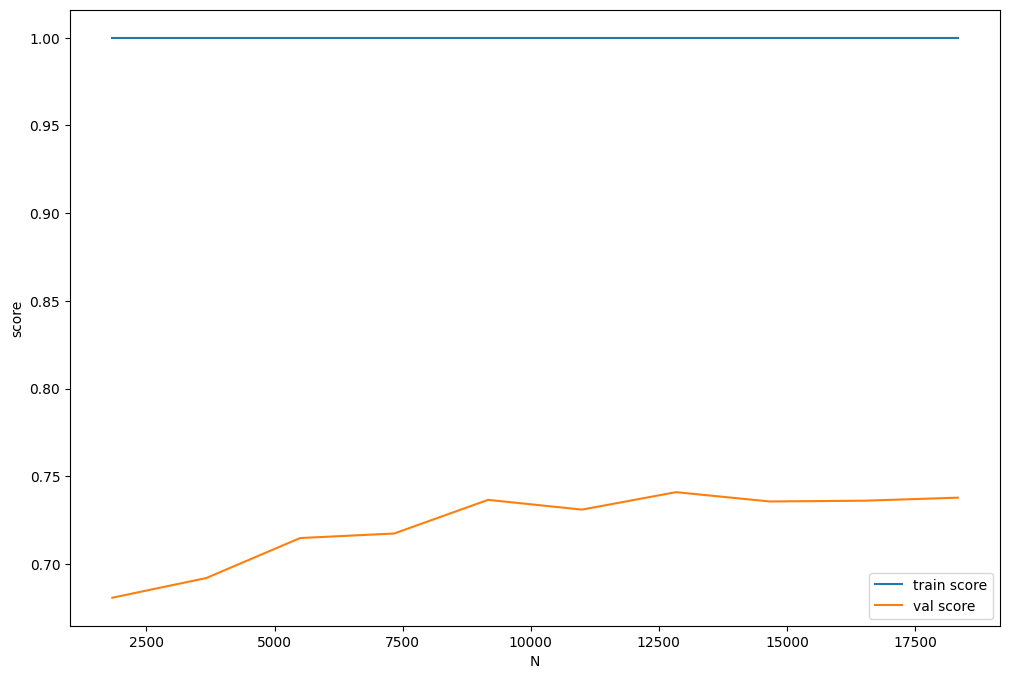

In [31]:
model1 = DecisionTreeClassifier(random_state=0)
performance_report(model1)

We will now use this function to analyze the performance of the models in the 'ML Algorithms' section. It displays everything about a model, and thanks to the 'learning_curve' graph, we can clearly see whether the model is overfitting or not.

For example, this model is obviously overfitted as it has 100% in the training step. To improve it, we will use the Grid Search model as we did above

#### Model 2: DecisionTreeClassifier with parameters selected using GridSearchCV:

Accuracy    :  0.9322834645669291
Recall      :  0.9322834645669291
Precision   :  0.9321302013237877
F1 Score    :  0.9290704281537875
Validation score :  0.8124871607520554

[[4472   65]
 [ 322  856]] 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4537
           1       0.93      0.73      0.82      1178

    accuracy                           0.93      5715
   macro avg       0.93      0.86      0.89      5715
weighted avg       0.93      0.93      0.93      5715



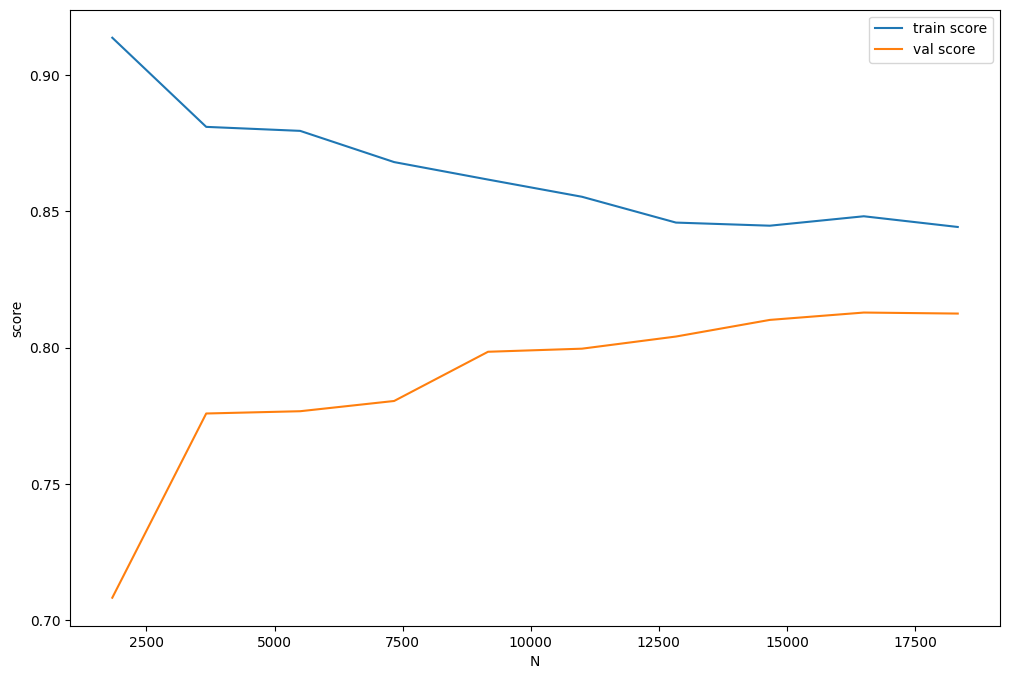

In [32]:
model2 = grid_model.best_estimator_
performance_report(model2)

Overall, this is a good model since it is far from overfitting on the training data, and the cross-validation score is also quite good, above 80. Now, we are confident that among the DecisionTreeClassifier models, this one is a solid choice.

# Feature Selection

Feature selection is the process of choosing the most important variables to improve model performance while reducing complexity. It helps prevent overfitting, enhances model interpretability, and reduces computation time. Techniques such as feature importance-based selection or recursive feature elimination (RFE) can be used to identify the most relevant features

In [33]:
X_train

,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,age_catego_20-30,age_catego_31-40,age_catego_41-50,age_catego_51-60,age_catego_60+
5758,46113,4.0,9000,15.99,0.20,4,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
27040,108000,11.0,25000,14.96,0.23,9,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1155,90000,7.0,17000,10.59,0.19,3,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6792,50000,5.0,2000,12.18,0.04,3,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2527,21000,3.0,3000,10.59,0.14,2,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,49600,8.0,2500,7.40,0.05,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
15294,60000,6.0,15000,13.35,0.25,3,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
26249,74797,1.0,10000,15.58,0.11,6,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
11519,69000,6.0,10000,15.62,0.14,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Feature_importance:

Feature importance refers to the technique used to rank the contribution of each feature to the model’s predictions. It helps identify which features have the most significant impact on the model’s performance.

In [34]:
model2.feature_importances_

array([1.24597622e-01, 4.43211025e-02, 9.01038785e-03, 2.04381135e-01,
       2.46182833e-01, 4.56124287e-03, 4.19687684e-03, 5.22164230e-04,
       3.01484705e-02, 1.78135684e-01, 2.57813293e-02, 0.00000000e+00,
       1.37530016e-02, 3.12890586e-02, 6.02545496e-04, 1.15885810e-02,
       0.00000000e+00, 0.00000000e+00, 4.17486171e-02, 2.14445425e-02,
       6.06206190e-04, 0.00000000e+00, 5.26243456e-03, 5.09825202e-04,
       1.75798642e-04, 9.38387881e-04, 2.42152741e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [35]:
pd.DataFrame(model2.feature_importances_, index=X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=False)


,importance
loan_percent_income,0.246183
loan_int_rate,0.204381
person_home_ownership_RENT,0.178136
person_income,0.124598
person_emp_length,0.044321
loan_grade_C,0.041749
loan_intent_MEDICAL,0.031289
person_home_ownership_OWN,0.030148
loan_intent_DEBTCONSOLIDATION,0.025781
loan_grade_D,0.021445


<Axes: >

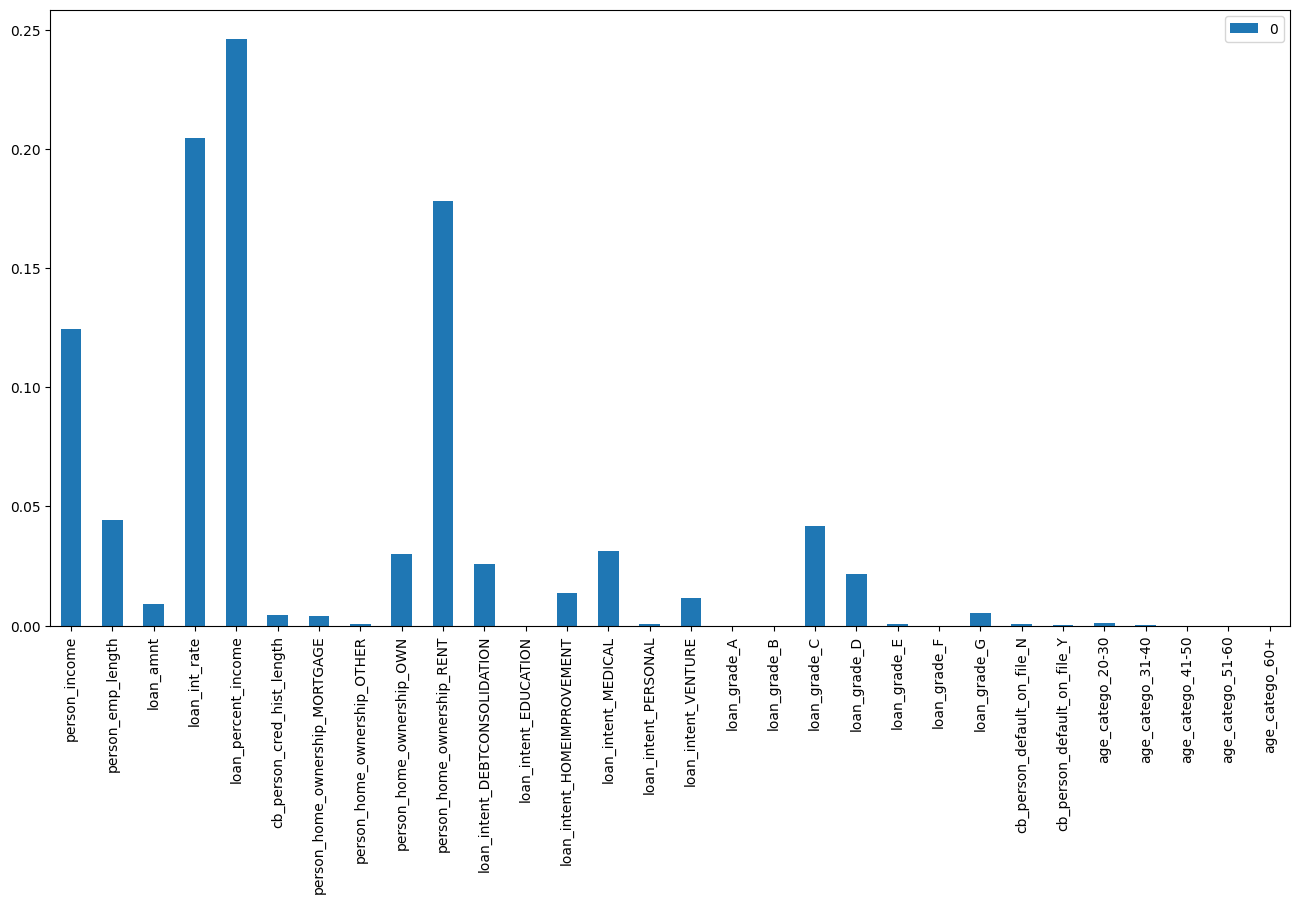

In [36]:
pd.DataFrame(model2.feature_importances_, index = X_train.columns).plot.bar(figsize=(16,8))


There are 30 columns in the dataset. We will split the data into two parts: categorical columns (24) and quantitative columns (6). After that, we will analyse each part with target variable.

In [37]:
quantitatif_columns = df.select_dtypes(exclude='object')
quantitatif_columns = quantitatif_columns.drop('loan_status', axis = 1)
quantitatif_columns = quantitatif_columns.columns.tolist()
quantitatif_columns

['person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [38]:
quantitatif = X_train[quantitatif_columns] # Above, we only specified the names of the columns and created a list. Here, we select those columns from X_train to ensure the size matches
quantitatif

,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
5758,46113,4.0,9000,15.99,0.20,4
27040,108000,11.0,25000,14.96,0.23,9
1155,90000,7.0,17000,10.59,0.19,3
6792,50000,5.0,2000,12.18,0.04,3
2527,21000,3.0,3000,10.59,0.14,2
...,...,...,...,...,...,...
6406,49600,8.0,2500,7.40,0.05,2
15294,60000,6.0,15000,13.35,0.25,3
26249,74797,1.0,10000,15.58,0.11,6
11519,69000,6.0,10000,15.62,0.14,2


In [39]:
catego = X_train.drop(quantitatif_columns, axis=1)
catego

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,...,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,age_catego_20-30,age_catego_31-40,age_catego_41-50,age_catego_51-60,age_catego_60+
5758,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
27040,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1155,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6792,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2527,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
15294,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
26249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
11519,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [40]:
catego_columns = catego.columns.tolist()
catego_columns

['person_home_ownership_MORTGAGE',
 'person_home_ownership_OTHER',
 'person_home_ownership_OWN',
 'person_home_ownership_RENT',
 'loan_intent_DEBTCONSOLIDATION',
 'loan_intent_EDUCATION',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_MEDICAL',
 'loan_intent_PERSONAL',
 'loan_intent_VENTURE',
 'loan_grade_A',
 'loan_grade_B',
 'loan_grade_C',
 'loan_grade_D',
 'loan_grade_E',
 'loan_grade_F',
 'loan_grade_G',
 'cb_person_default_on_file_N',
 'cb_person_default_on_file_Y',
 'age_catego_20-30',
 'age_catego_31-40',
 'age_catego_41-50',
 'age_catego_51-60',
 'age_catego_60+']

Thus, we split X_train into two parts without changing the number of rows! The first part contains 6 columns (only continuous), and the second part contains 24 columns (only categorical)

In [41]:
for col in quantitatif:
    print(f"Variance de {col} : {quantitatif[col].var()}")

Variance de person_income : 2823727562.550106
Variance de person_emp_length : 16.4591687368503
Variance de loan_amnt : 40193935.3693074
Variance de loan_int_rate : 10.461774348609167
Variance de loan_percent_income : 0.011339596033461206
Variance de cb_person_cred_hist_length : 16.336854768648262


Very interesting!

When performing feature importance, loan_per_income has the highest coefficient in the model. However, we also see that it has the least variance among the continuous variables.
The reason can be explained as follows:

-   Some models, such as decision trees or random forests, are less sensitive to the variance of features. These models can leverage even small variations to improve predictions.

-   Linear models, on the other hand, may be more affected by low-variance columns, as they rely on direct linear relationships

In other words, we conclude that when using decision trees, we do not discard small changes. This is something we typically do more with linear models

Now, let's perform dependence tests. The target is a categorical variable, so we will use the chi-square test for the relasionship target/categorical features, and for target/continuous features, the F-classification test will be used.

In [42]:
from sklearn.feature_selection import chi2, f_classif, SelectKBest

In [43]:
chi2(catego, y_train)

(array([4.78011088e+02, 3.35020893e+00, 2.33291996e+02, 6.57750728e+02,
        1.03433668e+02, 6.35542967e+01, 2.82336395e+01, 7.05579364e+01,
        1.13335798e+01, 1.14883852e+02, 6.53128046e+02, 1.47204425e+02,
        6.57230374e+00, 2.15087942e+03, 7.89043171e+02, 2.37082642e+02,
        1.72628289e+02, 1.41933454e+02, 6.43740208e+02, 1.97441515e+00,
        6.00564819e+00, 3.68815287e+00, 4.17661912e+00, 1.94725770e+00]),
 array([5.78799746e-106, 6.71964840e-002, 1.14139171e-052, 4.60782353e-145,
        2.69259821e-024, 1.56006963e-015, 1.07519587e-007, 4.46945909e-017,
        7.61180247e-004, 8.34444906e-027, 4.66471584e-144, 7.08015924e-034,
        1.03577793e-002, 0.00000000e+000, 1.30104813e-173, 1.70151448e-053,
        1.97309109e-039, 1.00561569e-032, 5.13455197e-142, 1.59979998e-001,
        1.42601544e-002, 5.48002726e-002, 4.09853836e-002, 1.62882666e-001]))

We are going to perform the Student's t-test. There are two hypotheses to test:

-   H0: "The variable is not significant."
-   H1: "The variable is significant." 

If the p-value is over 5% (or 0.05), then H0 is accepted, meaning the variable is not significant(important).

In [44]:
chi2_values, p_values = chi2(catego, y_train)
chi2_results = pd.DataFrame({'Column': catego.columns, 'Chi2 Value': chi2_values,'P-Value': p_values})
chi2_results['Chi2 Value'] = chi2_results['Chi2 Value'].map('{:.4f}'.format)
chi2_results['P-Value'] = chi2_results['P-Value'].map('{:.4f}'.format)
chi2_results = chi2_results.sort_values(by='P-Value', ascending=False)
chi2_results['P-Value'] = chi2_results['P-Value'].astype(float)
chi2_results

,Column,Chi2 Value,P-Value
23,age_catego_60+,1.9473,0.1629
19,age_catego_20-30,1.9744,0.1600
1,person_home_ownership_OTHER,3.3502,0.0672
21,age_catego_41-50,3.6882,0.0548
22,age_catego_51-60,4.1766,0.0410
20,age_catego_31-40,6.0056,0.0143
12,loan_grade_C,6.5723,0.0104
8,loan_intent_PERSONAL,11.3336,0.0008
7,loan_intent_MEDICAL,70.5579,0.0000
16,loan_grade_G,172.6283,0.0000


As we can see, we have only 4 variables that are not important, so we will remove them in the future.

In [45]:
catego

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,...,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,age_catego_20-30,age_catego_31-40,age_catego_41-50,age_catego_51-60,age_catego_60+
5758,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
27040,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1155,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6792,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2527,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
15294,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
26249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
11519,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [46]:
best_number_catego_features = 0
for i in chi2_results.iloc[:,2]:
    if i < 0.05:
        best_number_catego_features = best_number_catego_features +1
print(best_number_catego_features)

20


So, we will select 20 columns from the categorical features. The features to remove: age_catego_20-30, age_catego_60+, age_catego_41-50, person_home_ownership_OTHER

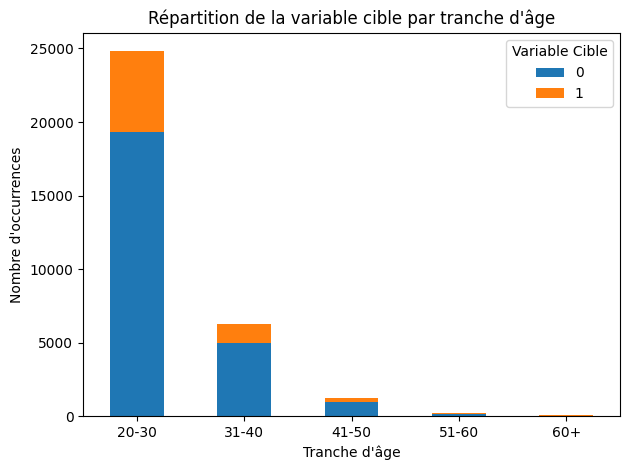

In [47]:
count_data = df.groupby(['age_catego', 'loan_status']).size().unstack(fill_value=0)

count_data.plot(kind='bar', stacked=True)
plt.title('Répartition de la variable cible par tranche d\'âge')
plt.xlabel('Tranche d\'âge')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=0) 
plt.legend(title='Variable Cible', loc='upper right')
plt.tight_layout()
plt.show()

Honestly, I didn't quite understand this. Why are age_catego_20-30 and age_catego_41-50 not selected? Actually, they had more distribution compared to the others.

SelectKBest is a feature selection method that selects the top K features based on their statistical significance in predicting the target variable. It works by applying a scoring function (such as chi-square, ANOVA, or mutual information) to each feature and selecting the top K features with the highest scores. 

In [48]:
selector = SelectKBest(chi2, k=20)
selector.fit_transform(catego,y_train)
selector.get_support()

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True, False])

For the relationship between target_catego and continuous variables, we will use the F-classification test

In [49]:
f_classif(quantitatif, y_train)

(array([ 636.76509411,  187.55393508,  300.77430623, 3004.52777815,
        3826.08685577,    4.18873891]),
 array([1.31743035e-138, 1.59883390e-042, 5.98167764e-067, 0.00000000e+000,
        0.00000000e+000, 4.07047417e-002]))

In [50]:
f, p_values = f_classif(quantitatif, y_train)

F_result = pd.DataFrame({'Column': quantitatif.columns, 'F': f,'P-Value': p_values})
F_result['F'] = F_result['F'].map('{:.4f}'.format)
F_result['P-Value'] = F_result['P-Value'].map('{:.4f}'.format)
F_result = F_result.sort_values(by='P-Value', ascending=False)
F_result['P-Value'] = F_result['P-Value'].astype(float)
F_result

,Column,F,P-Value
5,cb_person_cred_hist_length,4.1887,0.0407
0,person_income,636.7651,0.0000
1,person_emp_length,187.5539,0.0000
2,loan_amnt,300.7743,0.0000
3,loan_int_rate,3004.5278,0.0000
4,loan_percent_income,3826.0869,0.0000


In [51]:
best_number_quant_features = 0
for i in F_result.iloc[:,2]:
    if i < 0.05:
        best_number_quant_features = best_number_quant_features +1
print(best_number_quant_features)

6


All continues features are significatif. 

# Pipeline

Pipeline is a tool that helps streamline and automate the process of applying multiple transformations and modeling steps in sequence. It ensures that all steps, such as data preprocessing, feature selection, and model training, are applied in the correct order without data leakage

In [52]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, RFECV
from sklearn.compose import make_column_transformer

The numerical_pipeline and categorical_pipeline apply SelectKBest to select the top features from numerical and categorical data, respectively. The numerical_pipeline uses the F-classification (ANOVA) test, while the categorical_pipeline uses the chi-square (chi2) test to evaluate feature importance.

In [53]:
numerical_pipeline = make_pipeline(SelectKBest(f_classif, k=best_number_quant_features))
categorical_pipeline = make_pipeline(SelectKBest(chi2, k=best_number_catego_features))

Preprocessor combines the numerical_pipeline and categorical_pipeline using make_column_transformer. It applies the respective feature selection methods to the quantitative columns and categorical columns, ensuring that the appropriate transformations are applied to each type of feature:

In [54]:
prepocessor = make_column_transformer((numerical_pipeline, quantitatif_columns), (categorical_pipeline, catego_columns))
#prepocessor.get_feature_names_out()

# ML Algorithms

## 1. DecisionTree

DecisionTree_grid is a pipeline that first applies the preprocessor (which handles feature selection for both numerical and categorical columns) and then a DecisionTreeClassifier with specific parameters

Accuracy    :  0.931583552055993
Recall      :  0.931583552055993
Precision   :  0.9311230215011943
F1 Score    :  0.9284836775628461
Validation score :  0.8130398248767887

[[4465   72]
 [ 319  859]] 

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      4537
           1       0.92      0.73      0.81      1178

    accuracy                           0.93      5715
   macro avg       0.93      0.86      0.89      5715
weighted avg       0.93      0.93      0.93      5715



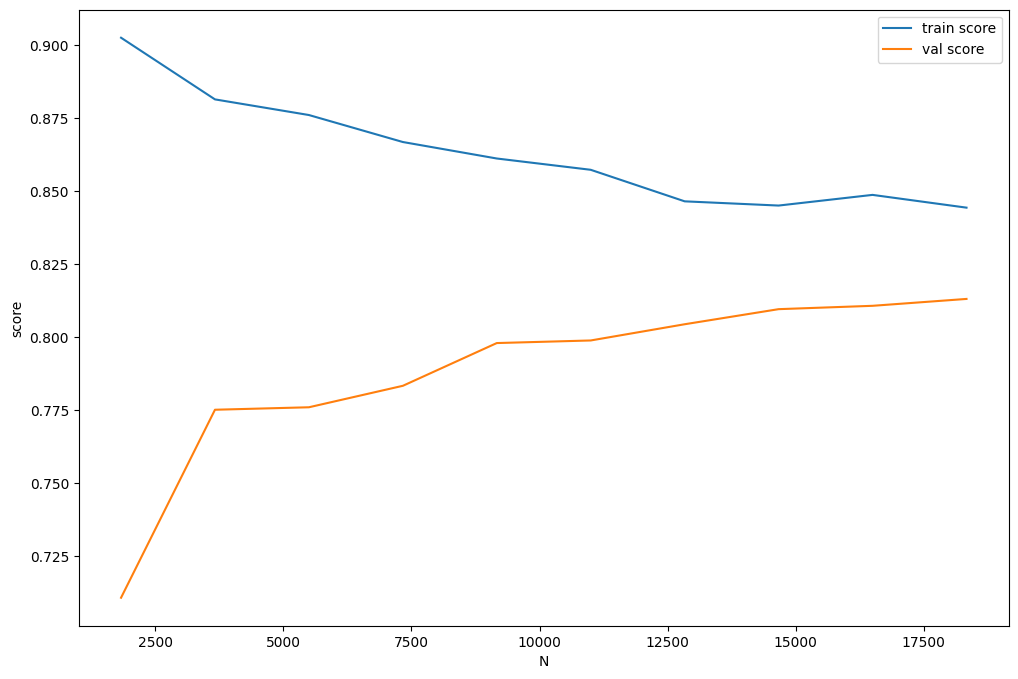

In [55]:
DecisionTree_grid = make_pipeline(prepocessor, DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=0))
performance_report(DecisionTree_grid)

To see the selected catego features:

## 2. SVM 

Reminder: The SVM model does not perform well when the target variable distribution is imbalanced. Since 0s are 4 times more frequent than 1s in our dataset, we can say the distribution is highly imbalanced. Why? Because, models on imbalanced data tend to be biased toward the majority class.

Therefore, models like SVM, KNN, and Logistic Regression will not perform well. However, I still wanted to show you the performance of SVM and KNN, even though they are likely to perform very poorly. 

If you absolutely want to use these models, you can perform oversampling on the dataset and then apply these algorithms.

In [56]:
from sklearn.svm import SVC, LinearSVC #cunki SVC avec petit taille des données (yani max 1000 ligne) effektivdir
from sklearn.preprocessing import StandardScaler


StandardScaler is a preprocessing tool used to standardize features by removing the mean and scaling to unit variance. It transforms each feature so that it has a mean of 0 and a standard deviation of 1. This is especially useful for algorithms sensitive to feature scaling, like support vector machines (SVMs), KNN and neural networks, as it helps improve convergence and performance. We will apply it only to continues features.

In [58]:
numerical_pip_standard = make_pipeline(SelectKBest(f_classif, k = best_number_quant_features), StandardScaler())

Accuracy    :  0.8719160104986876
Recall      :  0.8719160104986876
Precision   :  0.8645440675017807
F1 Score    :  0.8641509737988257
Validation score :  0.6434903429589706

[[4329  208]
 [ 524  654]] 

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4537
           1       0.76      0.56      0.64      1178

    accuracy                           0.87      5715
   macro avg       0.83      0.75      0.78      5715
weighted avg       0.86      0.87      0.86      5715



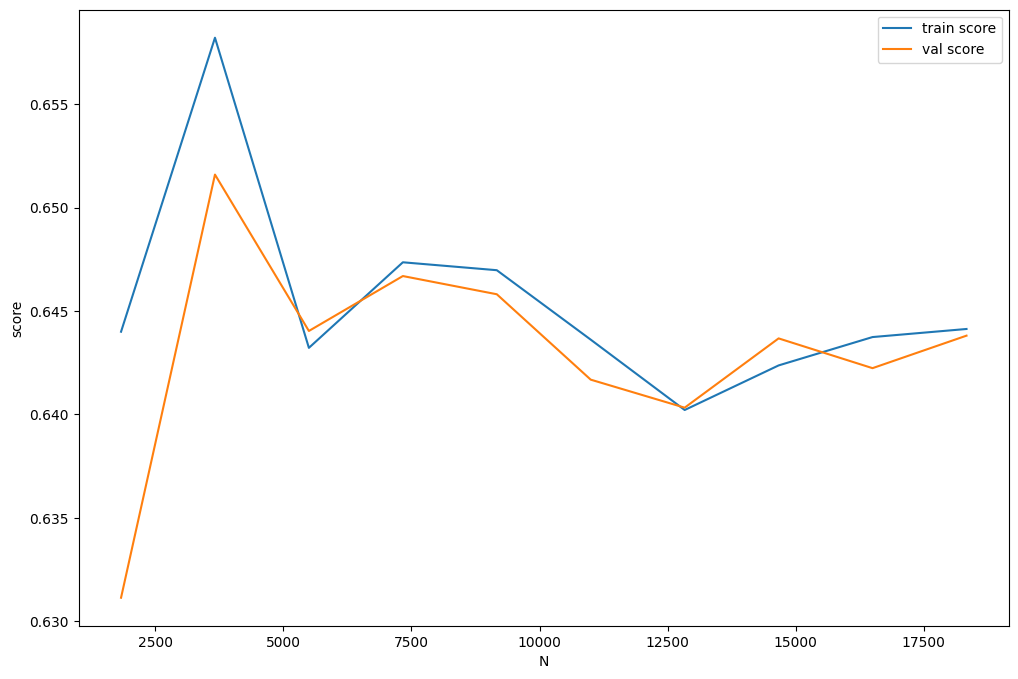

In [59]:
prepocessor = make_column_transformer((numerical_pip_standard, quantitatif_columns), (categorical_pipeline, catego_columns))
SVM = make_pipeline(prepocessor, LinearSVC())
performance_report(SVM)

Result analysis: The performance of model is awful. Despite being far from overfitting, the validation score is lower than the previous scores

In [60]:
from sklearn.model_selection import RandomizedSearchCV

In [61]:
parameters = {
    'linearsvc__penalty': ['l1', 'l2'],
    'linearsvc__loss': ['hinge', 'squared_hinge']
}

In [62]:
grid = GridSearchCV(SVM, parameters, scoring='f1', cv= 5)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

{'linearsvc__loss': 'hinge', 'linearsvc__penalty': 'l2'}
0.6507672860540161


Accuracy    :  0.8727909011373578
Recall      :  0.8727909011373578
Precision   :  0.8656691792971244
F1 Score    :  0.8659180964650482
Validation score :  0.651449858161243

[[4317  220]
 [ 507  671]] 

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4537
           1       0.75      0.57      0.65      1178

    accuracy                           0.87      5715
   macro avg       0.82      0.76      0.79      5715
weighted avg       0.87      0.87      0.87      5715



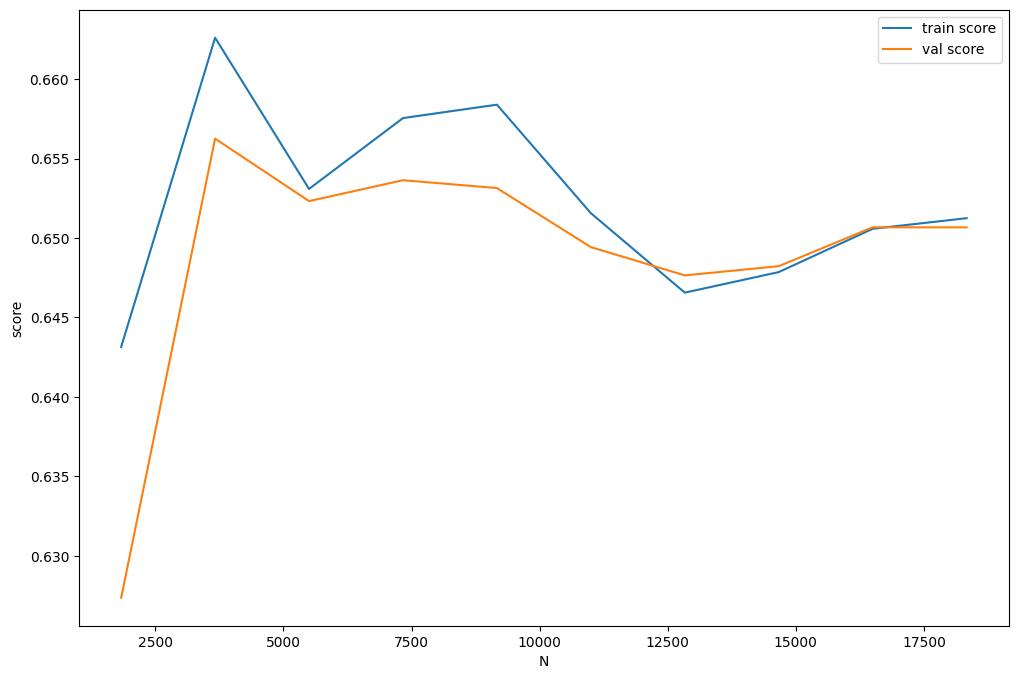

In [63]:
grid_svm = grid.best_estimator_
performance_report(grid_svm)

In any case, the score is below 0.70. This is actually quite normal, as SVM is not well-suited to datasets where the distribution in the target variable is unbalanced

## 3. KNN

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
KNN = make_pipeline(prepocessor, KNeighborsClassifier())

In [66]:
param_grid = {'kneighborsclassifier__n_neighbors': np.arange(5,20), 
              'kneighborsclassifier__metric': ['euclidean', 'manhattan'],
              'kneighborsclassifier__weights': ['uniform', 'distance'],
              'kneighborsclassifier__algorithm': ['ball_tree', 'kd_tree', 'brute']
              }

RandomizedSearchCV is a hyperparameter tuning method in scikit-learn that samples a fixed number of parameter settings from specified distributions and evaluates them through cross-validation. Unlike GridSearchCV, which exhaustively tries all combinations, RandomizedSearchCV is faster and more efficient for large parameter spaces because it randomly explores a subset. It does not try all possible combinations of parameters like GridSearchCV does. It picks parameters at random within the given ranges or lists, which can save time when the parameter space is large. While it doesn't guarantee to find the absolute best combination, it often provides a good solution more efficiently

In [67]:
random = RandomizedSearchCV(KNN, param_grid, scoring = 'f1', cv = 5, n_iter=20)
random.fit(X_train,y_train)
print(random.best_params_)
print(random.best_score_)


{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__algorithm': 'brute'}
0.7451211897211085


Accuracy    :  0.910761154855643
Recall      :  0.910761154855643
Precision   :  0.9094507276722307
F1 Score    :  0.9051849139734316
Validation score :  0.7451211897211085

[[4444   93]
 [ 417  761]] 

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      4537
           1       0.89      0.65      0.75      1178

    accuracy                           0.91      5715
   macro avg       0.90      0.81      0.85      5715
weighted avg       0.91      0.91      0.91      5715



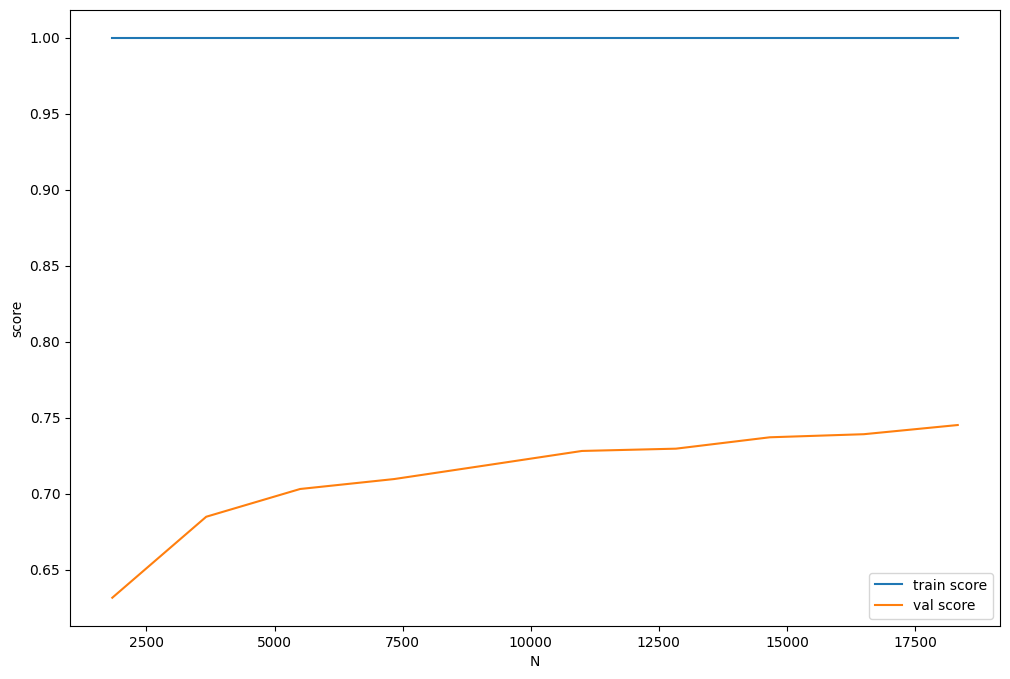

In [68]:
KNN_random = random.best_estimator_
performance_report(KNN_random)

Even though we have the best random parameters and a score around 0.75, this model is overfitting

## 4. Ensemble Learning

Ensemble Learning refers to a machine learning technique where multiple models are combined to solve a problem and improve performance. The idea is that by combining several models, the ensemble can make more accurate predictions than any single model.

### 4.1 Voting

In [69]:
from sklearn.ensemble import VotingClassifier

The VotingClassifier in this code combines three models: KNN_random, grid_svm, and DecisionTree_grid using hard voting. It aggregates their predictions and makes a final prediction based on the majority vote of these classifiers. This approach helps improve model's score by leveraging the strengths of different algorithms.

In [70]:

Voting = VotingClassifier(
                            [
                            ('KNN', KNN_random),
                            ('SVM', grid_svm),
                            ('DecisionTree', DecisionTree_grid)
                            ],
                            voting = 'hard')

Voting.fit(X_train, y_train)
score = cross_val_score(model, X_train, y_train, cv=5, scoring = 'f1').mean()
print(model.__class__.__name__, score)

DecisionTreeClassifier 0.8124871607520554


In [71]:
Voting

VotingClassifier(estimators=[('KNN',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                Pipeline(steps=[('selectkbest',
                                                                                                 SelectKBest(k=6)),
                                                                                                ('standardscaler',
                                                                                                 StandardScaler())]),
                                                                                ['person_income',
                                                                                 'person_emp_length',
                                                                                 'loan_amnt',
                                                                                 'loan_int_rate',
                                                                                 'loan_percent_income',
                                                                                 'cb_person_cred_hist_length']),
                                                                               ('pipeline-2',
                                                                                Pipeline(ste...
                                                                                 'loan_grade_B',
                                                                                 'loan_grade_C',
                                                                                 'loan_grade_D',
                                                                                 'loan_grade_E',
                                                                                 'loan_grade_F',
                                                                                 'loan_grade_G',
                                                                                 'cb_person_default_on_file_N',
                                                                                 'cb_person_default_on_file_Y',
                                                                                 'age_catego_20-30',
                                                                                 'age_catego_31-40',
                                                                                 'age_catego_41-50',
                                                                                 'age_catego_51-60',
                                                                                 'age_catego_60+'])])),
                                              ('decisiontreeclassifier',
                                               DecisionTreeClassifier(criterion='entropy',
                                                                      max_depth=11,
                                                                      random_state=0))]))])

### 4.2 Stacking

In [72]:
from sklearn.ensemble import StackingClassifier


The StackingClassifier in the code below combines three base models: KNN_random, grid_svm, and DecisionTree_grid, and uses a DecisionTreeClassifier as the final estimator. The base models make predictions, which are then used as input features for the final estimator to make the ultimate prediction. The goal of stacking is to leverage the strengths of multiple models and improve performance by training a meta-model (in this case, a decision tree) on the predictions of the base models.

In [73]:
Stacking = StackingClassifier(
                            [
                            ('KNN', KNN_random),
                            ('SVM', grid_svm),
                            ('DecisionTree', DecisionTree_grid)
                            ],
                            final_estimator = DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=0))

Stacking.fit(X_train, y_train)
val_score = cross_val_score(Stacking, X_train, y_train, cv=5, scoring='f1').mean()
print(f'validation score est : {val_score}')

validation score est : 0.792712105262274


The learning_curve function will take a lot of time; that's why I didn't run the code below.

In [74]:
# performance_report(Stacking)

### 4.3 Boosting


Boosting is an ensemble learning technique that combines multiple weak learners (typically simple models) to create a stronger model. The idea behind boosting is to train models sequentially, with each model focusing on the errors made by the previous ones, thus improving the overall performance.

In [75]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [76]:
preprocessor = make_column_transformer((numerical_pipeline, quantitatif_columns), (categorical_pipeline, catego_columns))

In [77]:
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(n_estimators=100))

Accuracy    :  0.8934383202099737
Recall      :  0.8934383202099737
Precision   :  0.8893608325636478
F1 Score    :  0.8901712745308151
Validation score :  0.716557183939444

[[4320  217]
 [ 392  786]] 

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      4537
           1       0.78      0.67      0.72      1178

    accuracy                           0.89      5715
   macro avg       0.85      0.81      0.83      5715
weighted avg       0.89      0.89      0.89      5715



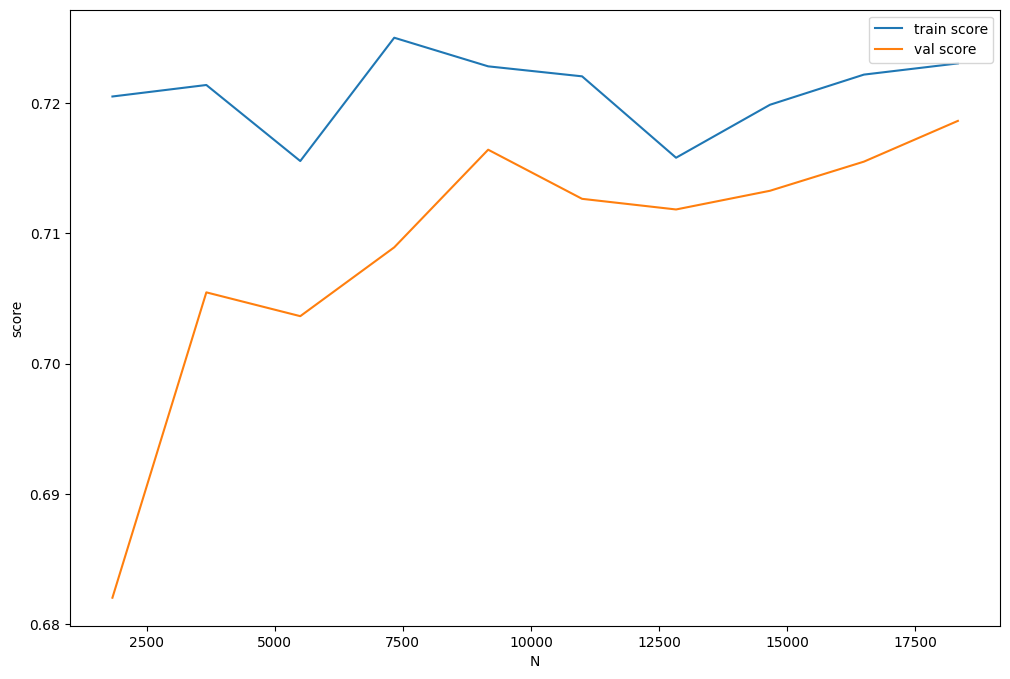

In [78]:
performance_report(AdaBoost)

Accuracy    :  0.9314085739282589
Recall      :  0.9314085739282589
Precision   :  0.9317121564373508
F1 Score    :  0.9278398916197096
Validation score :  0.8067988148836516

[[4480   57]
 [ 335  843]] 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4537
           1       0.94      0.72      0.81      1178

    accuracy                           0.93      5715
   macro avg       0.93      0.85      0.88      5715
weighted avg       0.93      0.93      0.93      5715



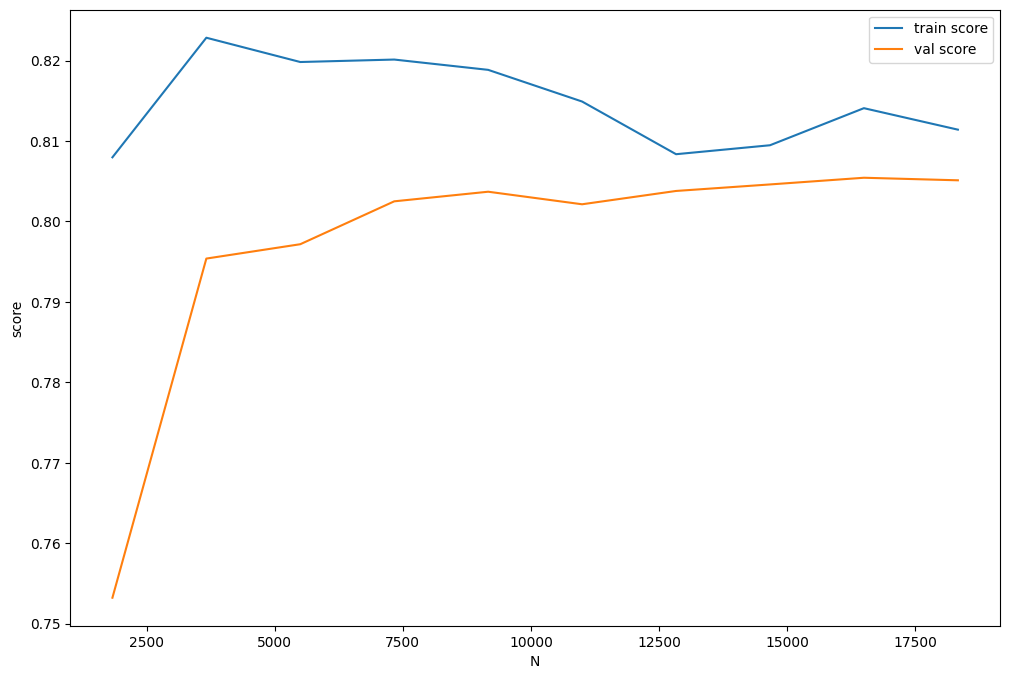

In [79]:
GradientBoosting = make_pipeline(preprocessor, GradientBoostingClassifier())
performance_report(GradientBoosting)

Try to optimize the model :

In [80]:
gradientboosting_param = {
    'gradientboostingclassifier__n_estimators': np.arange(10, 100, 10),     
    'gradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2],     
    'gradientboostingclassifier__max_depth': np.arange(3, 15, 1),             
    'gradientboostingclassifier__min_samples_split': np.arange(2, 10, 1),     
    'gradientboostingclassifier__min_samples_leaf': np.arange(1, 10, 1),      
    'gradientboostingclassifier__subsample': [0.7, 0.8, 0.9, 1.0],           
    'gradientboostingclassifier__max_features': ['auto', 'sqrt', 'log2'],     
    'gradientboostingclassifier__loss': ['deviance', 'exponential']          
}

In [81]:
randomize_gradientboosting = RandomizedSearchCV(GradientBoosting, gradientboosting_param, cv=5, scoring = 'f1', n_iter=40)
randomize_gradientboosting.fit(X_train, y_train)
print(randomize_gradientboosting.best_params_)
print(randomize_gradientboosting.best_score_)
GradientBoosting = randomize_gradientboosting.best_estimator_

{'gradientboostingclassifier__subsample': 0.7, 'gradientboostingclassifier__n_estimators': 90, 'gradientboostingclassifier__min_samples_split': 8, 'gradientboostingclassifier__min_samples_leaf': 6, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__max_depth': 11, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__learning_rate': 0.1}
0.8234470112481784


Accuracy    :  0.9357830271216098
Recall      :  0.9357830271216098
Precision   :  0.936244220386524
F1 Score    :  0.9326249008951376
Validation score :  0.8191576930218474

[[4486   51]
 [ 316  862]] 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4537
           1       0.94      0.73      0.82      1178

    accuracy                           0.94      5715
   macro avg       0.94      0.86      0.89      5715
weighted avg       0.94      0.94      0.93      5715



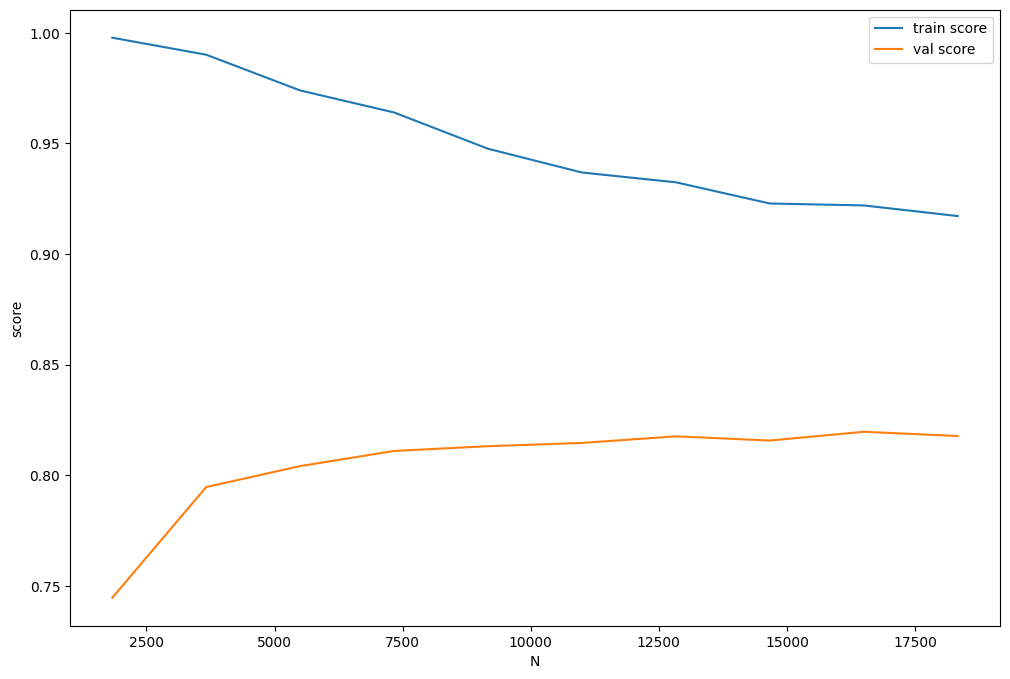

In [82]:
performance_report(GradientBoosting)

The model is not overfitting, and the validation score is good. Nice!

### 4.4 Bagging

Bagging is an ensemble method that improves model accuracy by training multiple models on different bootstrapped subsets of the training data, and then combining their predictions through averaging or majority voting.

RandomForest is a specific implementation of bagging, where the base learners are decision trees.

In [83]:
from sklearn.ensemble import RandomForestClassifier

Accuracy    :  0.9363079615048119
Recall      :  0.9363079615048119
Precision   :  0.9370386913749107
F1 Score    :  0.9330783014614359
Validation score :  0.8189175913934321

[[4491   46]
 [ 318  860]] 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4537
           1       0.95      0.73      0.83      1178

    accuracy                           0.94      5715
   macro avg       0.94      0.86      0.89      5715
weighted avg       0.94      0.94      0.93      5715



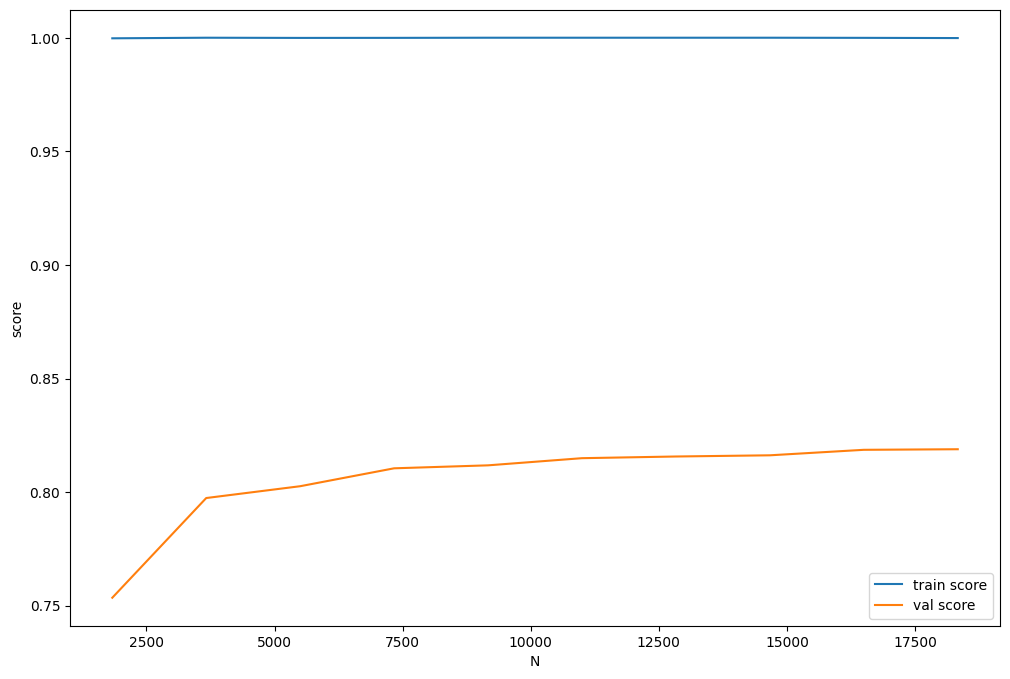

In [84]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
performance_report(RandomForest)

Model is overfitting. Try to improve by adding the new parameters into model

In [85]:
randomforest_param = {'randomforestclassifier__n_estimators' : np.arange(10, 100),
                      'randomforestclassifier__max_depth': np.arange(1, 20),
                     'randomforestclassifier__criterion': ["gini", "entropy", "log_loss"]}

In [86]:
randomized_randomforest = RandomizedSearchCV(RandomForest, randomforest_param, cv=5, scoring = 'f1', n_iter=40)
randomized_randomforest.fit(X_train, y_train)
print(randomized_randomforest.best_params_)
print(randomized_randomforest.best_score_)


{'randomforestclassifier__n_estimators': 58, 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__criterion': 'log_loss'}
0.8188194815982431


Accuracy    :  0.937007874015748
Recall      :  0.937007874015748
Precision   :  0.9384964395945797
F1 Score    :  0.9335339756844713
Validation score :  0.8188194815982431

[[4503   34]
 [ 326  852]] 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4537
           1       0.96      0.72      0.83      1178

    accuracy                           0.94      5715
   macro avg       0.95      0.86      0.89      5715
weighted avg       0.94      0.94      0.93      5715



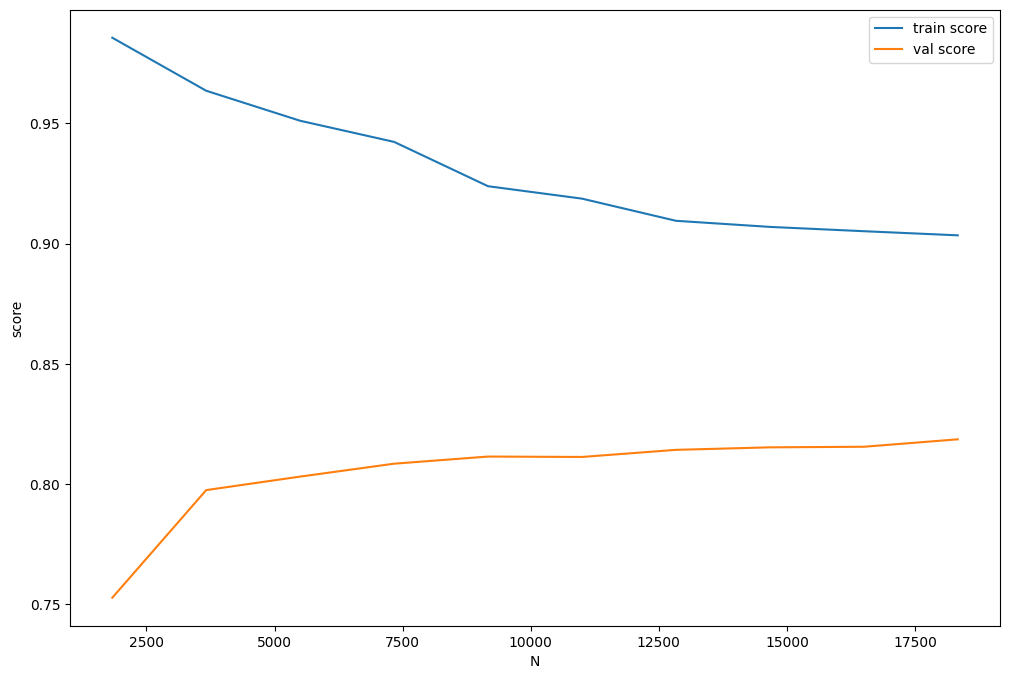

In [87]:
RandomForest = randomized_randomforest.best_estimator_
performance_report(RandomForest)

This is also a good model as it is far from overfitting in training and has a score over 80% in the validation.

In [88]:
model_dict = {
    "DecisionTree": DecisionTree_grid,
    "SVM": grid_svm,
    "KNN": KNN_random,
    "Voting": Voting,
    "Stacking": Stacking,
    "AdaBoost": AdaBoost,
    "GradientBoosting": GradientBoosting,
    "RandomForest": RandomForest
}

for name, model in model_dict.items():
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    acccuracy = accuracy_score(y_test, ypred)
    recall = recall_score(y_test, ypred, average="weighted")
    precision = precision_score(y_test, ypred, average="weighted")
    f1 = f1_score(y_test, ypred, average="weighted")
    validation_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()

    print(f'{name} results:')
    print("Accuracy    : ", acccuracy)
    print("Recall      : ", recall)
    print("Precision   : ", precision)
    print("F1 Score    : ", f1)
    print(f"Validation score :  {validation_score}\n")

    

DecisionTree results:
Accuracy    :  0.931583552055993
Recall      :  0.931583552055993
Precision   :  0.9311230215011943
F1 Score    :  0.9284836775628461
Validation score :  0.8130398248767887

SVM results:
Accuracy    :  0.8733158355205599
Recall      :  0.8733158355205599
Precision   :  0.8662570208356604
F1 Score    :  0.8664430718345968
Validation score :  0.6506782907747578

KNN results:
Accuracy    :  0.910761154855643
Recall      :  0.910761154855643
Precision   :  0.9094507276722307
F1 Score    :  0.9051849139734316
Validation score :  0.7451211897211085

Voting results:
Accuracy    :  0.9181102362204724
Recall      :  0.9181102362204724
Precision   :  0.9176422068513681
F1 Score    :  0.9131835900100158
Validation score :  0.7702583184065818

Stacking results:
Accuracy    :  0.9294838145231846
Recall      :  0.9294838145231846
Precision   :  0.9292544377521861
F1 Score    :  0.9259852002750666
Validation score :  0.7918872815496738

AdaBoost results:
Accuracy    :  0.8934383

I realized that RandomForest and GradientBoosting have best performance based on Validation and F1 score. So, I'll prepare my prediction function based on this model

# Prediction

In [89]:
RandomForest

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('selectkbest',
                                                                   SelectKBest(k=6))]),
                                                  ['person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('selectkbest',
                                                                   SelectKBest(k=20,
                                                                               score_func=<function chi2 at 0x00000236...
                                                   'loan_grade_C',
                                                   'loan_grade_D',
                                                   'loan_grade_E',
                                                   'loan_grade_F',
                                                   'loan_grade_G',
                                                   'cb_person_default_on_file_N',
                                                   'cb_person_default_on_file_Y',
                                                   'age_catego_20-30',
                                                   'age_catego_31-40',
                                                   'age_catego_41-50',
                                                   'age_catego_51-60',
                                                   'age_catego_60+'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='log_loss', max_depth=17,
                                        n_estimators=58, random_state=0))])

In [90]:
X_train.columns

Index(['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N',
       'cb_person_default_on_file_Y', 'age_catego_20-30', 'age_catego_31-40',
       'age_catego_41-50', 'age_catego_51-60', 'age_catego_60+'],
      dtype='object')

My annual income is around 24,000. I have 2 years of experience. I want to borrow 30,000 with a 3% interest rate. So, my loan_percent_income = 30,000 / 24,000 = 1.25. My credit history length is 0, and my ownership status is Rent. Regarding my loan grade, I don't think it is very good because this is my first credit. So, maybe it could be a D, which indicates a riskier credit. Default on life is 'N' and I'm 27 years old.

In [91]:
my_data = (24000,2,30000,3,1.25,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0)

In [92]:
def Prediction(model, input_values, features):    
    input_df = pd.DataFrame([input_values], columns=features)    
    prediction = model.predict(input_df)
    proba  = model.predict_proba(input_df)
    print(f'Loan status is {prediction} with the probability : {proba}')

In [93]:
Prediction(RandomForest, my_data, X_train.columns)

Loan status is [1] with the probability : [[0.05172414 0.94827586]]


So, I have only 8% of change being 0, in other words, being a non-default client. Very bad... Lol

# SECOND Feature Engineering

### Reminder: This part of the notebook is not very important because I wasn't able to improve the performance; on the contrary, I found the results worse than before. So, you are not obliged to run the code in this section. It's just to show how we can modify the data to find an effective result.

In this step, I transformed all historical columns (like person_emp_length, cb_person_cred_hist_length, person_age) into categorical columns.

In [94]:
df1 = data.copy()
df1.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<Axes: >

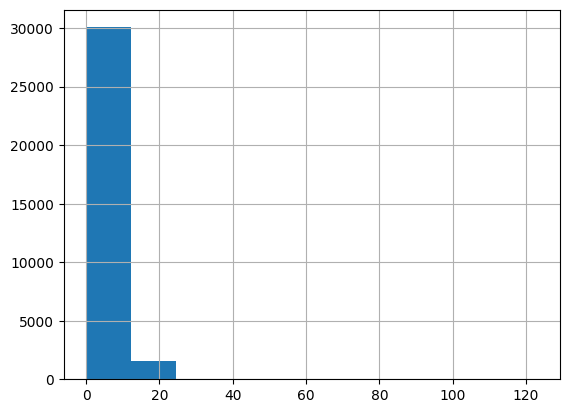

In [95]:
df1['person_emp_length'].hist()

<Axes: >

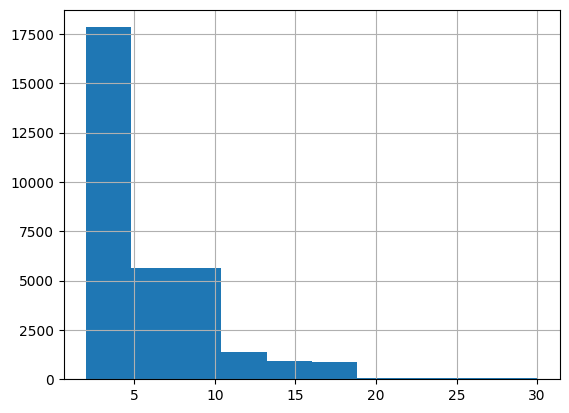

In [96]:
df1['cb_person_cred_hist_length'].hist()

In [97]:
def feature_engineering(dataset):
    dataset = imputation(dataset)
    dataset = dataset.drop(dataset[dataset['person_age'] > 100].index, axis=0)
    dataset = dataset.drop(dataset[dataset['person_emp_length'] > 60].index, axis=0)

    dataset['age_catego'] = pd.cut(dataset['person_age'],bins=[18, 30, 40, 50, 60, 100],labels=['20-30', '31-40', '41-50', '51-60', '60+'])
    dataset['age_catego'] = dataset['age_catego'].astype('object')

    dataset['person_emp_length_catego'] = pd.cut(dataset['person_emp_length'],bins=[0, 5, 10, 15, 20, float('inf')],labels=['0-4', '5-9', '10-14', '15-19', '20+'],right=False)
    dataset['person_emp_length_catego'] = dataset['person_emp_length_catego'].astype('object')
    
    dataset['cb_person_cred_hist_length_catego'] = pd.cut(dataset['cb_person_cred_hist_length'],bins=[0, 5, 10, 15, 20, float('inf')],labels=['0-4', '5-9', '10-14', '15-19', '20+'],right=False)
    dataset['cb_person_cred_hist_length_catego'] = dataset['cb_person_cred_hist_length_catego'].astype('object')
    
    dataset = dataset.drop(['cb_person_cred_hist_length', 'person_age', 'person_emp_length'], axis=1)
    return dataset

In [98]:
df1 = feature_engineering(df1)
df1

,person_income,person_home_ownership,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,age_catego,person_emp_length_catego,cb_person_cred_hist_length_catego
1,9600,OWN,EDUCATION,B,1000,11.14,0,0.10,N,20-30,5-9,0-4
2,9600,MORTGAGE,MEDICAL,C,5500,12.87,1,0.57,N,20-30,0-4,0-4
3,65500,RENT,MEDICAL,C,35000,15.23,1,0.53,N,20-30,0-4,0-4
4,54400,RENT,MEDICAL,C,35000,14.27,1,0.55,Y,20-30,5-9,0-4
5,9900,OWN,VENTURE,A,2500,7.14,1,0.25,N,20-30,0-4,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,53000,MORTGAGE,PERSONAL,C,5800,13.16,0,0.11,N,51-60,0-4,20+
32577,120000,MORTGAGE,PERSONAL,A,17625,7.49,0,0.15,N,51-60,0-4,15-19
32578,76000,RENT,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,60+,0-4,20+
32579,150000,MORTGAGE,PERSONAL,B,15000,11.48,0,0.10,N,51-60,5-9,20+


In [99]:
df1['person_emp_length_catego'].value_counts()

person_emp_length_catego
0-4      15522
5-9       9841
10-14     2498
15-19      637
20+        134
Name: count, dtype: int64

In [100]:
df1.isna().sum()/df1.shape[0]

person_income                        0.0
person_home_ownership                0.0
loan_intent                          0.0
loan_grade                           0.0
loan_amnt                            0.0
loan_int_rate                        0.0
loan_status                          0.0
loan_percent_income                  0.0
cb_person_default_on_file            0.0
age_catego                           0.0
person_emp_length_catego             0.0
cb_person_cred_hist_length_catego    0.0
dtype: float64

In [101]:
trainset, testset = train_test_split(df1, test_size=0.2, random_state=3)

In [102]:
trainset['loan_status'].value_counts()

loan_status
0    17944
1     4961
Name: count, dtype: int64

In [103]:
testset['loan_status'].value_counts()

loan_status
0    4486
1    1241
Name: count, dtype: int64

In [104]:
def prepocessing(dataset):

    dataset = encoder(dataset)
    dataset = imputation(dataset)
    X = dataset.drop('loan_status', axis = 1)
    y = dataset['loan_status']

    print(y.value_counts())

    return X, y

In [105]:
X_train, y_train = prepocessing(trainset)
X_test, y_test = prepocessing(testset)

loan_status
0    17944
1     4961
Name: count, dtype: int64
loan_status
0    4486
1    1241
Name: count, dtype: int64


In [106]:
X_train

,person_income,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,...,person_emp_length_catego_0-4,person_emp_length_catego_10-14,person_emp_length_catego_15-19,person_emp_length_catego_20+,person_emp_length_catego_5-9,cb_person_cred_hist_length_catego_0-4,cb_person_cred_hist_length_catego_10-14,cb_person_cred_hist_length_catego_15-19,cb_person_cred_hist_length_catego_20+,cb_person_cred_hist_length_catego_5-9
13409,91000,15000,7.88,0.16,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8787,60000,8000,13.49,0.13,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
26089,96000,2500,12.99,0.03,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12659,84000,25000,10.25,0.30,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
28762,48000,10000,7.51,0.21,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17390,84000,5000,10.99,0.06,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
29851,24000,4400,14.09,0.18,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13113,70550,12000,15.68,0.14,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1937,70000,2000,12.84,0.03,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Accuracy    :  0.8782957918631046
Recall      :  0.8782957918631046
Precision   :  0.8797498138740469
F1 Score    :  0.8789715068328514
Validation score :  0.7319854416793284

[[4118  368]
 [ 329  912]] 

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4486
           1       0.71      0.73      0.72      1241

    accuracy                           0.88      5727
   macro avg       0.82      0.83      0.82      5727
weighted avg       0.88      0.88      0.88      5727



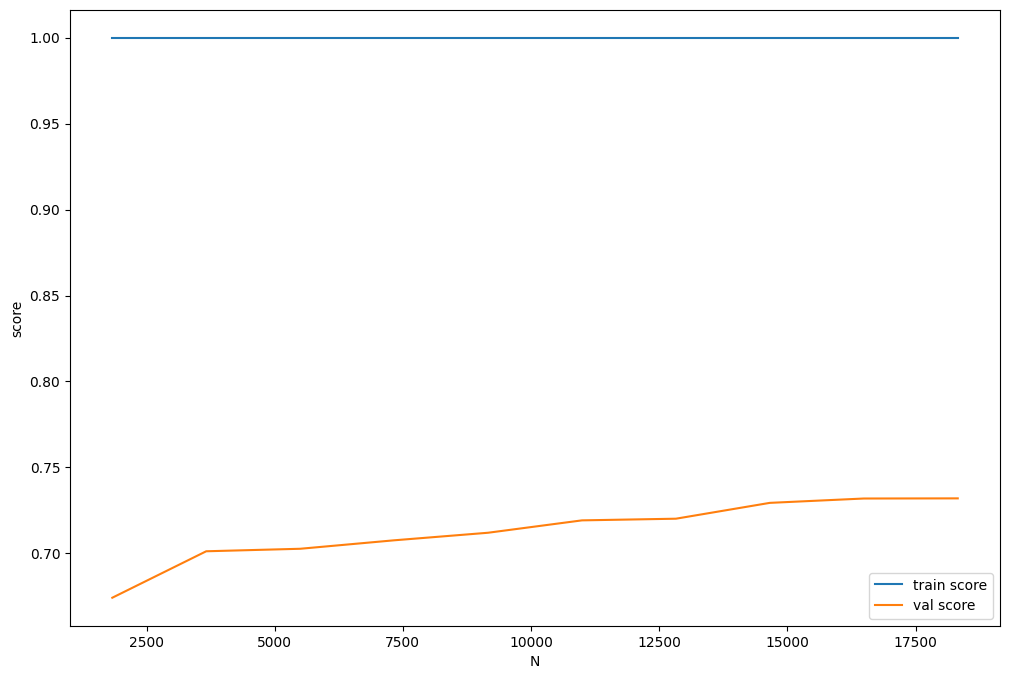

In [107]:
model1 = DecisionTreeClassifier(random_state=0)
performance_report(model1)

Overfitting

In [108]:
grid_param = {'max_depth' : np.arange(1, 20), 
              'criterion': ["gini", "entropy", "log_loss"] 
              }

grid_model = GridSearchCV(DecisionTreeClassifier(random_state=0), grid_param, cv = 5, scoring='f1')
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_score_)

{'criterion': 'entropy', 'max_depth': 8}
0.8026552255167534


DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=0)
Accuracy    :  0.9158372620918457
Recall      :  0.9158372620918457
Precision   :  0.9168680687244916
F1 Score    :  0.9103591490754664
Validation score :  0.8026552255167534

[[4424   62]
 [ 420  821]] 

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      4486
           1       0.93      0.66      0.77      1241

    accuracy                           0.92      5727
   macro avg       0.92      0.82      0.86      5727
weighted avg       0.92      0.92      0.91      5727



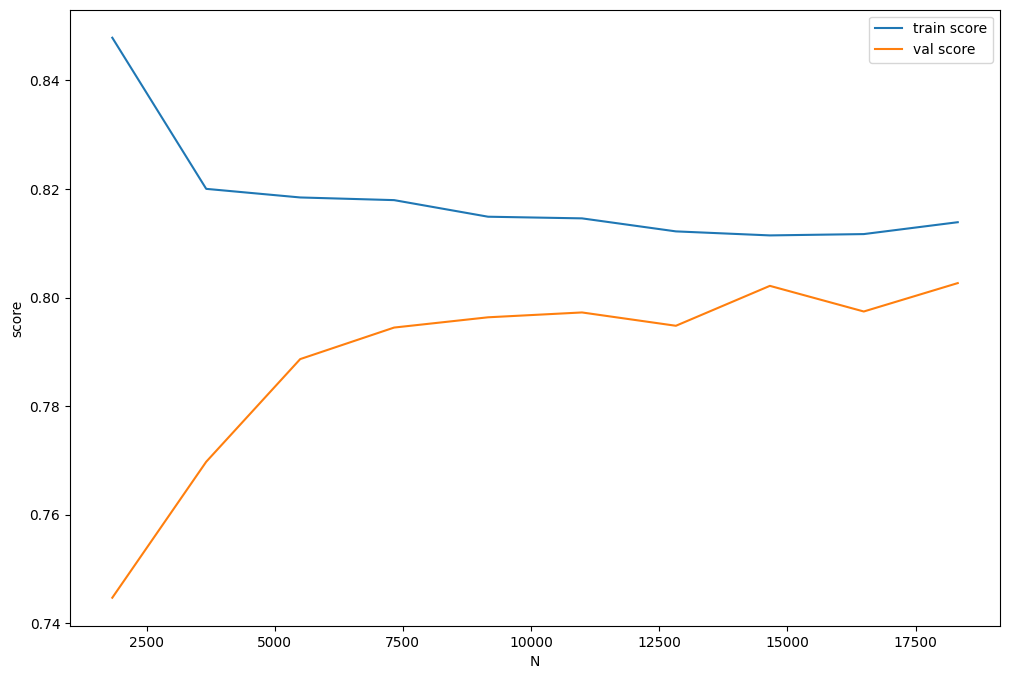

In [109]:
model2 = grid_model.best_estimator_
print(model2)
performance_report(model2)

In [110]:
pd.DataFrame(model2.feature_importances_, index=X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=False)


,importance
loan_percent_income,0.278289
loan_int_rate,0.220751
person_home_ownership_RENT,0.175832
person_income,0.100919
loan_grade_C,0.045608
loan_intent_MEDICAL,0.034847
person_home_ownership_OWN,0.033332
loan_intent_DEBTCONSOLIDATION,0.028426
person_emp_length_catego_0-4,0.021782
loan_grade_D,0.018641


In [111]:
quantitatif_columns = df1.select_dtypes(exclude='object')
quantitatif_columns = quantitatif_columns.drop('loan_status', axis = 1)
quantitatif_columns = quantitatif_columns.columns.tolist()
quantitatif_columns

['person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']

In [112]:
quantitatif = X_train[quantitatif_columns] # Above, we only specified the names of the columns and created a list. Here, we select those columns from X_train to ensure the size matches
quantitatif

,person_income,loan_amnt,loan_int_rate,loan_percent_income
13409,91000,15000,7.88,0.16
8787,60000,8000,13.49,0.13
26089,96000,2500,12.99,0.03
12659,84000,25000,10.25,0.30
28762,48000,10000,7.51,0.21
...,...,...,...,...
17390,84000,5000,10.99,0.06
29851,24000,4400,14.09,0.18
13113,70550,12000,15.68,0.14
1937,70000,2000,12.84,0.03


In [113]:
catego = X_train.drop(quantitatif_columns, axis=1)
catego

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,...,person_emp_length_catego_0-4,person_emp_length_catego_10-14,person_emp_length_catego_15-19,person_emp_length_catego_20+,person_emp_length_catego_5-9,cb_person_cred_hist_length_catego_0-4,cb_person_cred_hist_length_catego_10-14,cb_person_cred_hist_length_catego_15-19,cb_person_cred_hist_length_catego_20+,cb_person_cred_hist_length_catego_5-9
13409,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8787,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
26089,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12659,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
28762,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17390,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
29851,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13113,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1937,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [114]:
catego_columns = catego.columns.tolist()
catego_columns

['person_home_ownership_MORTGAGE',
 'person_home_ownership_OTHER',
 'person_home_ownership_OWN',
 'person_home_ownership_RENT',
 'loan_intent_DEBTCONSOLIDATION',
 'loan_intent_EDUCATION',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_MEDICAL',
 'loan_intent_PERSONAL',
 'loan_intent_VENTURE',
 'loan_grade_A',
 'loan_grade_B',
 'loan_grade_C',
 'loan_grade_D',
 'loan_grade_E',
 'loan_grade_F',
 'loan_grade_G',
 'cb_person_default_on_file_N',
 'cb_person_default_on_file_Y',
 'age_catego_20-30',
 'age_catego_31-40',
 'age_catego_41-50',
 'age_catego_51-60',
 'age_catego_60+',
 'person_emp_length_catego_0-4',
 'person_emp_length_catego_10-14',
 'person_emp_length_catego_15-19',
 'person_emp_length_catego_20+',
 'person_emp_length_catego_5-9',
 'cb_person_cred_hist_length_catego_0-4',
 'cb_person_cred_hist_length_catego_10-14',
 'cb_person_cred_hist_length_catego_15-19',
 'cb_person_cred_hist_length_catego_20+',
 'cb_person_cred_hist_length_catego_5-9']

In [115]:
for col in quantitatif:
    print(f"Variance de {col} : {quantitatif[col].var()}")

Variance de person_income : 2778054304.1522512
Variance de loan_amnt : 39658028.239243776
Variance de loan_int_rate : 10.398409636323033
Variance de loan_percent_income : 0.01131042852819696


In [116]:
chi2_values, p_values = chi2(catego, y_train)

chi2_results = pd.DataFrame({'Column': catego.columns, 'Chi2 Value': chi2_values,'P-Value': p_values})
chi2_results['Chi2 Value'] = chi2_results['Chi2 Value'].map('{:.4f}'.format)
chi2_results['P-Value'] = chi2_results['P-Value'].map('{:.4f}'.format)
chi2_results = chi2_results.sort_values(by='P-Value', ascending=False)
chi2_results['P-Value'] = chi2_results['P-Value'].astype(float)
chi2_results

,Column,Chi2 Value,P-Value
31,cb_person_cred_hist_length_catego_15-19,0.5939,0.4409
19,age_catego_20-30,1.5887,0.2075
22,age_catego_51-60,1.7140,0.1905
23,age_catego_60+,1.8628,0.1723
27,person_emp_length_catego_20+,2.0430,0.1529
32,cb_person_cred_hist_length_catego_20+,2.4786,0.1154
1,person_home_ownership_OTHER,3.1318,0.0768
12,loan_grade_C,3.3134,0.0687
20,age_catego_31-40,3.8371,0.0501
21,age_catego_41-50,4.4334,0.0352


In [117]:
best_number_catego_features = 0
for i in chi2_results.iloc[:,2]:
    if i < 0.05:
        best_number_catego_features = best_number_catego_features +1
print(best_number_catego_features)

25


In [118]:
f, p_values = f_classif(quantitatif, y_train)

F_result = pd.DataFrame({'Column': quantitatif.columns, 'F': f,'P-Value': p_values})
F_result['F'] = F_result['F'].map('{:.4f}'.format)
F_result['P-Value'] = F_result['P-Value'].map('{:.4f}'.format)
F_result = F_result.sort_values(by='P-Value', ascending=False)
F_result['P-Value'] = F_result['P-Value'].astype(float)
F_result

,Column,F,P-Value
0,person_income,640.5867,0.0
1,loan_amnt,294.2859,0.0
2,loan_int_rate,2960.3651,0.0
3,loan_percent_income,3960.2366,0.0


In [119]:
best_number_quant_features = 0
for i in F_result.iloc[:,2]:
    if i < 0.05:
        best_number_quant_features = best_number_quant_features +1
print(best_number_quant_features)

4


In [120]:
numerical_pipeline = make_pipeline(SelectKBest(f_classif, k=best_number_quant_features))
categorical_pipeline = make_pipeline(SelectKBest(chi2, k=best_number_catego_features))
preprocessor = make_column_transformer((numerical_pipeline, quantitatif_columns), (categorical_pipeline, catego_columns))


In [121]:
model2 = DecisionTreeClassifier(max_depth=8, random_state=0)

Accuracy    :  0.9156626506024096
Recall      :  0.9156626506024096
Precision   :  0.9149784141570322
F1 Score    :  0.9111411545667166
Validation score :  0.7987285397683879

[[4397   89]
 [ 394  847]] 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4486
           1       0.90      0.68      0.78      1241

    accuracy                           0.92      5727
   macro avg       0.91      0.83      0.86      5727
weighted avg       0.91      0.92      0.91      5727



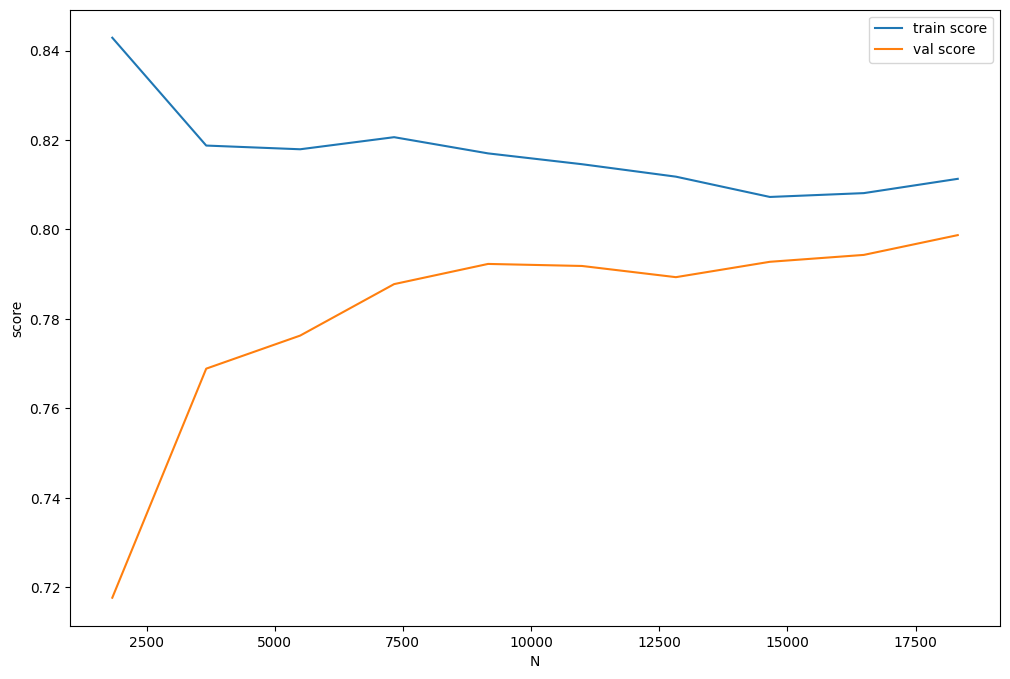

In [122]:
model2 = make_pipeline(preprocessor, model2)
performance_report(model2)

To conclude, with this feature engineering, we didn’t achieve better performance than with the previous feature engineering

Accuracy    :  0.9191548803911297
Recall      :  0.9191548803911297
Precision   :  0.9195276142977703
F1 Score    :  0.9144773953321316
Validation score :  0.8057775718671634

[[4417   69]
 [ 394  847]] 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4486
           1       0.92      0.68      0.79      1241

    accuracy                           0.92      5727
   macro avg       0.92      0.83      0.87      5727
weighted avg       0.92      0.92      0.91      5727



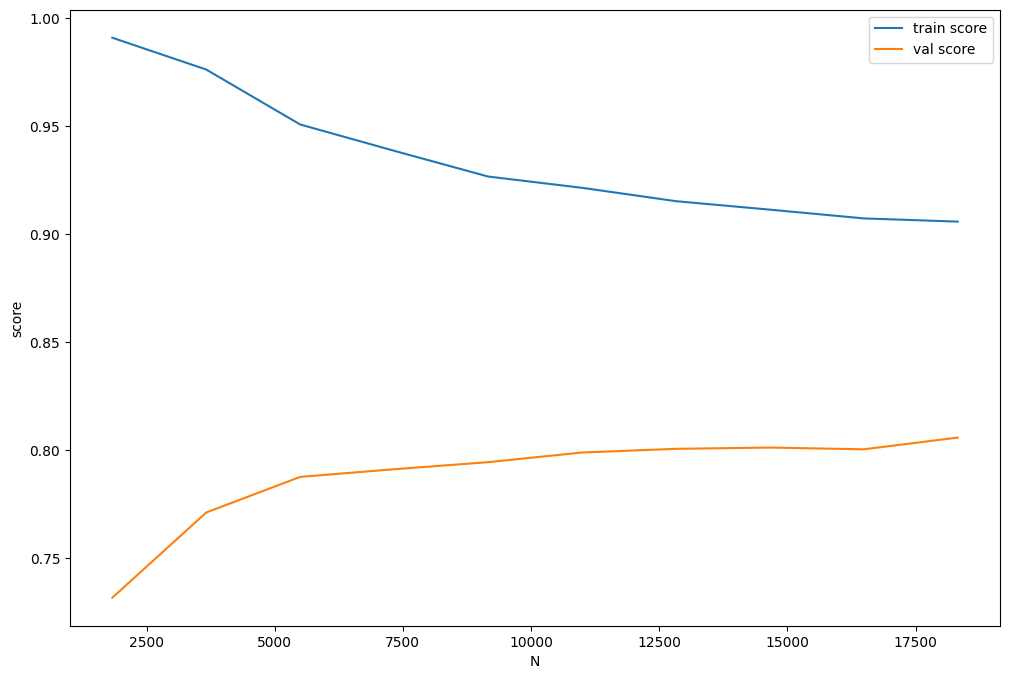

In [125]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(criterion='log_loss', max_depth=17, n_estimators=58,
                       random_state=0))

performance_report(RandomForest)


Accuracy    :  0.9207263837960538
Recall      :  0.9207263837960538
Precision   :  0.9212915516835477
F1 Score    :  0.9161568418054813
Validation score :  0.808123988810107

[[4421   65]
 [ 389  852]] 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4486
           1       0.93      0.69      0.79      1241

    accuracy                           0.92      5727
   macro avg       0.92      0.84      0.87      5727
weighted avg       0.92      0.92      0.92      5727



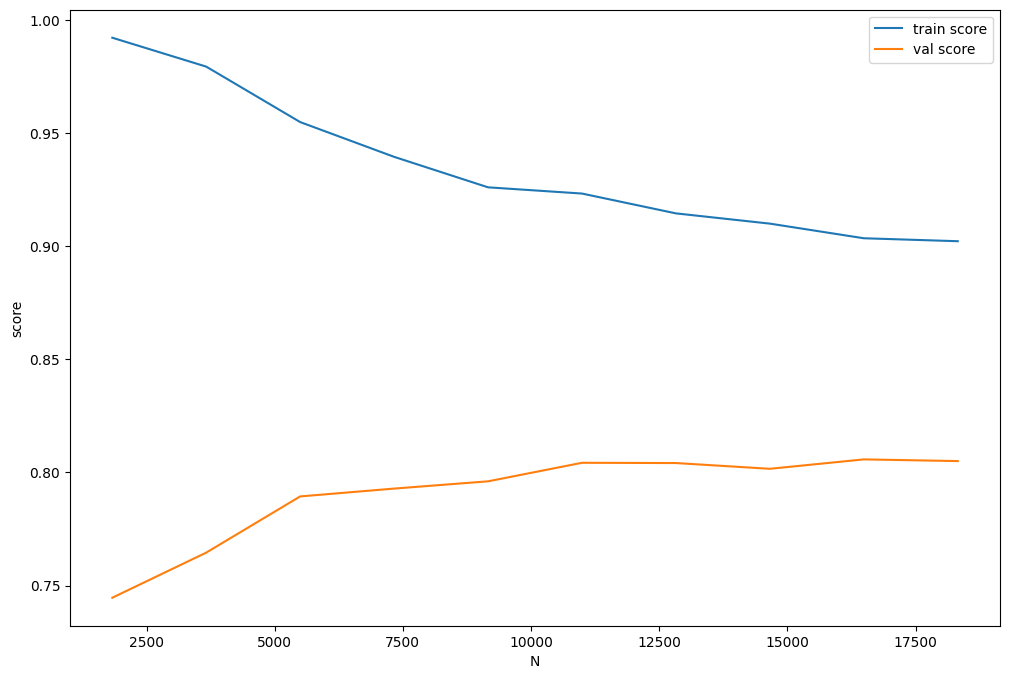

In [127]:
GradientBoosting = make_pipeline(preprocessor, GradientBoostingClassifier(loss='exponential', max_depth=11,
                           max_features='sqrt', min_samples_leaf=6,
                           min_samples_split=8, n_estimators=90, subsample=0.7))
performance_report(GradientBoosting)

In [135]:
X_train.columns

Index(['person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N',
       'cb_person_default_on_file_Y', 'age_catego_20-30', 'age_catego_31-40',
       'age_catego_41-50', 'age_catego_51-60', 'age_catego_60+',
       'person_emp_length_catego_0-4', 'person_emp_length_catego_10-14',
       'person_emp_length_catego_15-19', 'person_emp_length_catego_20+',
       'person_emp_length_catego_5-9', 'cb_person_cred_hist_length_catego_0-4',
       'cb_person_cred_hist_length_catego_10-14',
       'cb_person_cred_hist_l

In [129]:
my_data = (24000,30000,3,1.25,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0)

In [130]:
Prediction(GradientBoosting, my_data, X_train.columns)

Loan status is [1] with the probability : [[1.99287770e-04 9.99800712e-01]]


After the new feature engineering, when we compare the performance of both RandomForest and GradientBoosting with the previous ones, we see that we haven't improved the performance; in fact, there is even a slight decline